# Schooling in Xenopus tadpoles

This notebook:

1. Loads and pre-processes the data
1. Calculates inter-tadpole distances
1. Calculates inter-tadpole angles
1. Processes all data, visualizes every frame, outputs all results in a csv file
1. Re-loads control and treatment data, processes each of them, then compares the result, and visualizes the differece
1. Reshuffles control data, compares real data to reshuffled data to check whether the distribution of tadpoles in the bowl was non-random; visualizes the difference

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.spatial
import scipy.stats as stats
from typing import List,Tuple

## 1. Load and pre-process the data

The data is pre-processed into one table with three columns:

* Tad: Tadpole number
* Frame: Frame number
* X and Y: coordinates of either tadpole tails or tadpole heads.

We assume that the ImageJ processing was performed correctly, and every odd row represent a position of a tadpole head, while every even row is a tail. We also assume that the first column in the sourse files runs from 1 to 2n (where n is the number of tadpoles in each frame), and then starts anew. We update this first column to run from 1 to n with repetitions, and add a column for Frames.

In [2]:
def preProcess(d):
    """Pre-process the data."""
    assert d.shape[0] % 2 == 0, "The number of rows in the data file should be even."
    d.columns = ['Tad']+[d.columns[i].replace(' ','') for i in range(1,len(d.columns))] # Remove spaces in column names
    d.insert(1, 'Frame', 0)
    
    for i in range(1,d.shape[0]):                           # Run through all entries
        if d.loc[i,'Tad'] < d.loc[i-1,'Tad']:               # If tadpole numbering has restarted
            d.loc[i,'Frame'] = d.loc[i-1,'Frame']+1         # Start a new frame
            assert d.loc[i-1,'Tad'] % 2 == 0, f"Odd number of points in frame {d.loc[i-1,'Frame']}"
        else:
            d.loc[i,'Frame'] = d.loc[i-1,'Frame']
    d.Frame = d.Frame.astype(int)                           # Set Frame type to int
    d.Tad = (d.Tad-1) // 2 + 1                              # Go from point# to tadpole#
    d = d.drop(['Min', 'Max', 'Area'], axis=1)              # Drop unused columns
    return d

data = pd.read_csv('data/control.csv')

data = preProcess(data)
print(data[:8])

   Tad  Frame      X       Y
0    1      0  7.391  14.783
1    1      0  7.232  14.643
2    2      0  8.850  14.623
3    2      0  8.670  14.443
4    3      0  7.751  12.426
5    3      0  7.491  12.186
6    4      0  5.394  13.285
7    4      0  5.334  13.065


## 2. Tools to Process Distances

A set of functions to:

1. Go from pairs of points into a new representation, with heads (X,Y) and tails (TX, TY) of each tadpole represented as different columns in the dataframe. Also, make "tails" relative to the head.
1. Perform Delaunay triangulation, identify neighboring tadpoles
1. Create a new dataframe ("pairs") to collect data about pairs of tadpoles, rather than individual tadpoles.
1. Calculate distances betwen neighboring tadpoles. Add these distances as yet another column in the data frame

Layout of Tadpole dataframe:
       x       y     tx    ty
0  7.391  14.783 -0.159 -0.14
1  8.850  14.623 -0.180 -0.18
2  7.751  12.426 -0.260 -0.24

Layout of Pairs dataframe:
    i   j      dist
0  16  17  5.154548
1  17   6  5.622530
2   6  16  4.820149


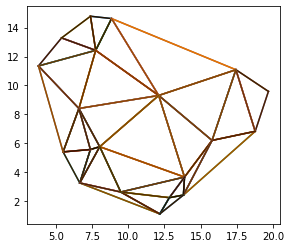

In [3]:
def getNFrames(d):
    """Returns the total number of frames."""
    return max(d.Frame)

def extractTads(d,frame):
    """Splits the data into XY position of each head, and _relative_ XY position of each tail."""
    xy = d.loc[d.Frame==frame,['X','Y']].to_numpy()
    heads = xy[0::2,:]
    tails = xy[1::2,:]-heads
    return pd.DataFrame({'x':heads[:,0] , 'y':heads[:,1] , 'tx':tails[:,0] , 'ty':tails[:,1]})  

def findNeighbors(tads): # Returns a new data frame, for edges
    """Triangulates the field, finds "neighbors". No thresholding of distance."""
    xy = tads[['x','y']]
    tri = scipy.spatial.Delaunay(xy,qhull_options="QJ").simplices # Help says that this "QJ" is needed if you want to
                                                                  # have all tadpoles in the output (even lonely ones)
    listOfPairs = [] # Array of tuples to describe all pairs of points
    for i in range(tri.shape[0]): # Go through all edges of Delaunay triangles, include each one only once
        t = [tuple(tri[i,[0,1]]) , tuple(tri[i,[1,2]]) , tuple(tri[i,[2,0]])]
        for p in t:
            if not p in listOfPairs:
                listOfPairs += [p]
    out = pd.DataFrame({'i':[a for (a,b) in listOfPairs] , 'j':[b for (a,b) in listOfPairs]})
    return out

def findDistances(tads,pairs):
    """Calculates distances between pairs of neighboring tadpoles."""
    xy = tads[['x','y']].values
    dist = [np.linalg.norm(xy[p[0],]-xy[p[1],]) for p in pairs[['i','j']].values.tolist()]
    pairs['dist'] = dist
    return pairs

# --- Test, for the first frame
tads = extractTads(data,frame=0)
pairs = findNeighbors(tads)
pairs = findDistances(tads,pairs)

print('Layout of Tadpole dataframe:')
print(tads[:3])
print('\nLayout of Pairs dataframe:')
print(pairs[:3])

# Test figure with edge colors proportional to their distance
fig = plt.figure()
ax = fig.add_subplot(111)
xy = tads[['x','y']].values
for i in range(len(pairs)):
    p = pairs[['i','j']].values.tolist()[i]
    ax.plot([xy[p[0],0] , xy[p[1],0]],[xy[p[0],1] , xy[p[1],1]]) # Point
    ax.plot(*([xy[p[i],_] for i in range(2)] for _ in range(2)),
           color=np.array([1,0.5,0])*pairs['dist'].iloc[i]/pairs[['dist']].max().values*0.9) 
    # The awkward line above draws lines between neighboring tadpoles
ax.set_aspect('equal')

## 3. Tools to Process Angles

A function to calculate angles (in degrees) between neighboring tadpoles. Updates the "pairs" dataframe.

Also a "comprehensive visualization of tadpoles positions and orientations" for one frame, as a visual troubleshooting aid.

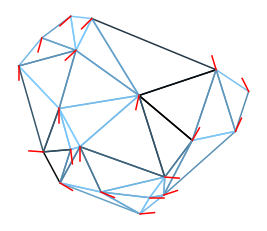

In [4]:
def findAngles(tads,pairs):
    '''Angles between pairs of tadpoles'''
    tails = tads[['tx','ty']].values # Go from pandas to lists, to effectively utilize list comprehension
    norms = [np.linalg.norm(tails[i,]) for i in range(tails.shape[0])]
    angle = [np.arccos(np.dot(tails[p[0],],tails[p[1],])/(norms[p[0]]*norms[p[1]])) 
             for p in pairs[['i','j']].values.tolist()]
    pairs['angle'] = np.array(angle)/np.pi*180
    return pairs

def niceTadFigure(ax,tads,pairs):
    """Nice picture for troubleshooting."""
    xy = tads[['x','y']].values
    tails = tads[['tx','ty']].values
    ang = pairs[['angle']].values
    for i in range(len(pairs)):
        p = pairs[['i','j']].values.tolist()[i]
        ax.plot(*([xy[p[i],_] for i in range(2)] for _ in range(2)),
           color=np.array([0.5,0.8,1])*(1-ang[i]/max(ang))) # Same as above, but weirdly written ;)
    for i in range(xy.shape[0]):
        nm = np.linalg.norm(tails[i,])
        ax.plot(xy[i,0]+[0,tails[i,0]/nm], xy[i,1]+[0,tails[i,1]/nm] , '-',color='red')
    ax.set_aspect('equal')
    ax.axis('off')

# --- Test, for the first frame
pairs = findAngles(tads,pairs)
    
fig = plt.figure()
ax = fig.add_subplot(111)
niceTadFigure(ax,tads,pairs)

## 4. Process everything, visualize the dataset, and save the data

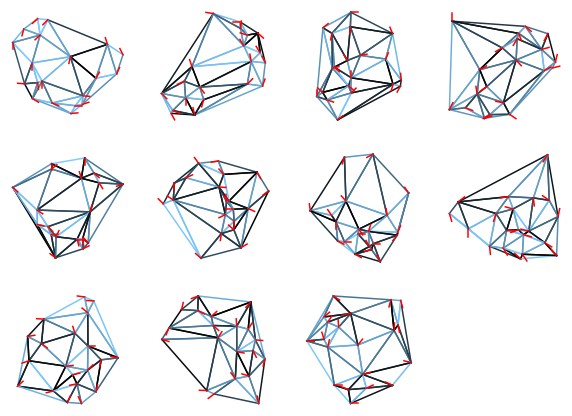

In [5]:
def processEverything(d, show_image=True):
    """Process one full dataset."""
    if show_image:
        fig = plt.figure(figsize=(10,10));

    fullDf = pd.DataFrame()
    for iframe in range(getNFrames(d)):
        tads = extractTads(d,frame=iframe)
        pairs = findNeighbors(tads)
        pairs = findDistances(tads,pairs)
        angl = findAngles(tads,pairs)

        pairs['frame'] = [iframe]*len(pairs)
        fullDf = fullDf.append(pd.DataFrame(pairs))    

        if show_image:
            ax = fig.add_subplot(4,4,iframe+1)
            niceTadFigure(ax,tads,pairs)
    return fullDf
    
out = processEverything(data)

out.to_csv('data/processed_data_output.csv', index=False) # index=False suppresses row numbers

## 5. Compare control data to treatment data

In [6]:
# Load and process the data
data = pd.read_csv('data/control.csv')
data = preProcess(data)
out = processEverything(data, show_image=False)

data = pd.read_csv('data/treatment.csv')
data = preProcess(data)
out_treatment = processEverything(data, show_image=False)

Are the inter-tadpole distances different between real and reshuffled data?
(was their clumping?)
T-test: t =  -3.6363311502659568 ; p-value =  0.0002837653654213907

Was the distribution of distances non-random, from frame to frame?
Kolmogorov-Smirnov test p-value =  1.2929369053171769e-07


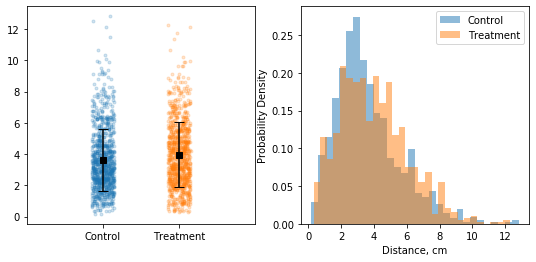

In [7]:
def two_groups_plot(y1, y2, labels):
    """A basic two-groups plot"""
    plt.plot(1+(np.random.uniform(size=y1.shape[0])-0.5)*0.3, y1, '.', alpha=0.2, zorder=-1)
    plt.plot(2+(np.random.uniform(size=y2.shape[0])-0.5)*0.3, y2, '.', alpha=0.2, zorder=-1)
    # Zorder is set to negative to hack around a bug in matplotlib that places errorbars below plots
    plt.errorbar(1, np.mean(y1), np.std(y1), color='k', marker='s', capsize=5)
    plt.errorbar(2, np.mean(y2), np.std(y2), color='k', marker='s', capsize=5)
    plt.xlim(0,3)
    plt.xticks(ticks=[1,2], labels=labels)

def compare_distances(out1,out2,labels):
    """Visualizes distances, reports a stat test"""
    d = out1['dist'].values
    d2 = out2['dist'].values

    plt.figure(figsize=(9,4))
    ax = plt.subplot(121)
    two_groups_plot(d, d2, labels)
    
    ax = plt.subplot(122)
    plt.hist(d , bins=30, density=True, alpha=0.5);
    plt.hist(d2, bins=30, density=True, alpha=0.5);
    plt.xlabel('Distance, cm')
    plt.ylabel('Probability Density')
    plt.legend(labels, loc='upper right')

    print('Are the inter-tadpole distances different between real and reshuffled data?')
    print('(was their clumping?)')
    test_results = stats.ttest_ind(d,d2)
    print('T-test: t = ', test_results.statistic, '; p-value = ',test_results.pvalue)

    print('\nWas the distribution of distances non-random, from frame to frame?')
    test_results = scipy.stats.ks_2samp(d,d2)
    print('Kolmogorov-Smirnov test p-value = ',test_results.pvalue)

compare_distances(out, out_treatment, ['Control','Treatment'])


Was the distribution of distances non-random, from frame to frame?
Kolmogorov-Smirnov test p-value =  0.022510651758386735


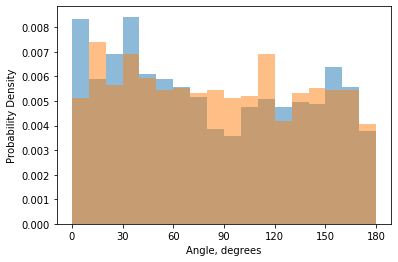

In [8]:
def compare_angles(out, out2, labels):
    """Visualizes angles, reports a stat test."""
    a = out['angle'].values
    a2 = out2['angle'].values

    plt.hist(a , bins=np.arange(0,180+10,10), density=True, alpha=0.5);
    plt.hist(a2, bins=np.arange(0,180+10,10), density=True, alpha=0.5);
    plt.xticks(np.arange(0,180+30,30))
    plt.xlabel('Angle, degrees')
    plt.ylabel('Probability Density')

    print('\nWas the distribution of distances non-random, from frame to frame?')
    test_results = scipy.stats.ks_2samp(a,a2)
    print('Kolmogorov-Smirnov test p-value = ',test_results.pvalue)
    
compare_angles(out, out_treatment, ['Control','Treatment'])

## 6. For the control dataset, reshuffle the data, compare real data to reshuffled

If the notebook is executed cell by cell, by now the results of the pairwise analysis (angles are distances) are stored in the dataframe "out". Below, we create a new dataframe "out_shuffled" that contains same analysis, but on the reshuffled data (with tadpoles randomly reshuffled between frames).

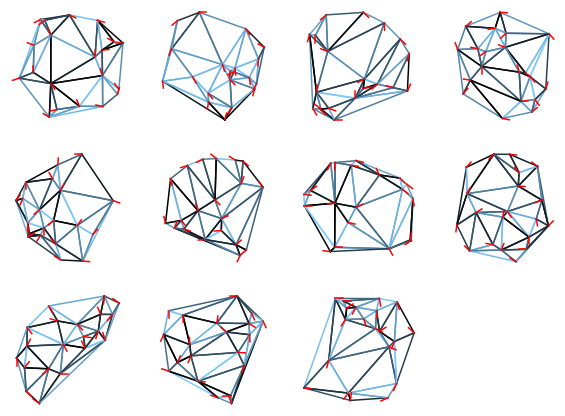

In [9]:
# Time to reshuffle
def shuffleTads(d):
    '''Reshuffles tadpoles within between frames'''
    nd = d.copy()
    p = np.random.permutation(len(d)//2)
    i = [a for sublist in [[2*j,2*j+1] for j in p] for a in sublist] # Looks like [2 3 0 1 4 5] etc. Weird syntax, huh?
    nd = nd.iloc[i]
    nd = nd.reset_index()
    nd['Frame'] = d['Frame'] # After everything was reshuffled, reset frame numbers
    return nd

data_shuffled = shuffleTads(data)
out_shuffled = processEverything(data_shuffled)

Are the inter-tadpole distances different between real and reshuffled data?
(was their clumping?)
T-test: t =  -2.9193142132167376 ; p-value =  0.003548231334052231

Was the distribution of distances non-random, from frame to frame?
Kolmogorov-Smirnov test p-value =  8.1667310800837e-05


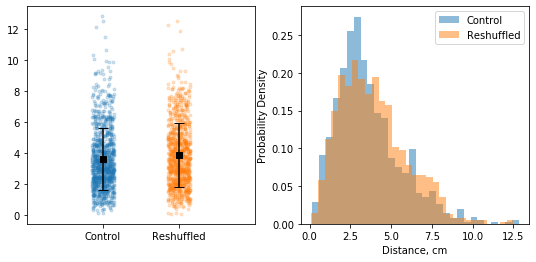

In [10]:
# Compare proper and randomized distances
compare_distances(out, out_shuffled, ['Control','Reshuffled'])


Was the distribution of distances non-random, from frame to frame?
Kolmogorov-Smirnov test p-value =  0.271766635926173


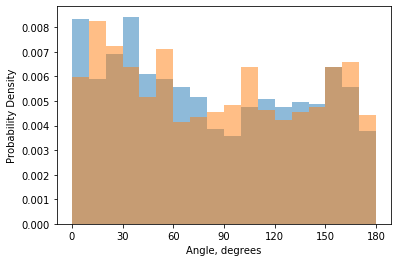

In [11]:
# Compare proper and randomized angles
compare_angles(out, out_shuffled, ['Control','Reshuffled'])